In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn


import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color



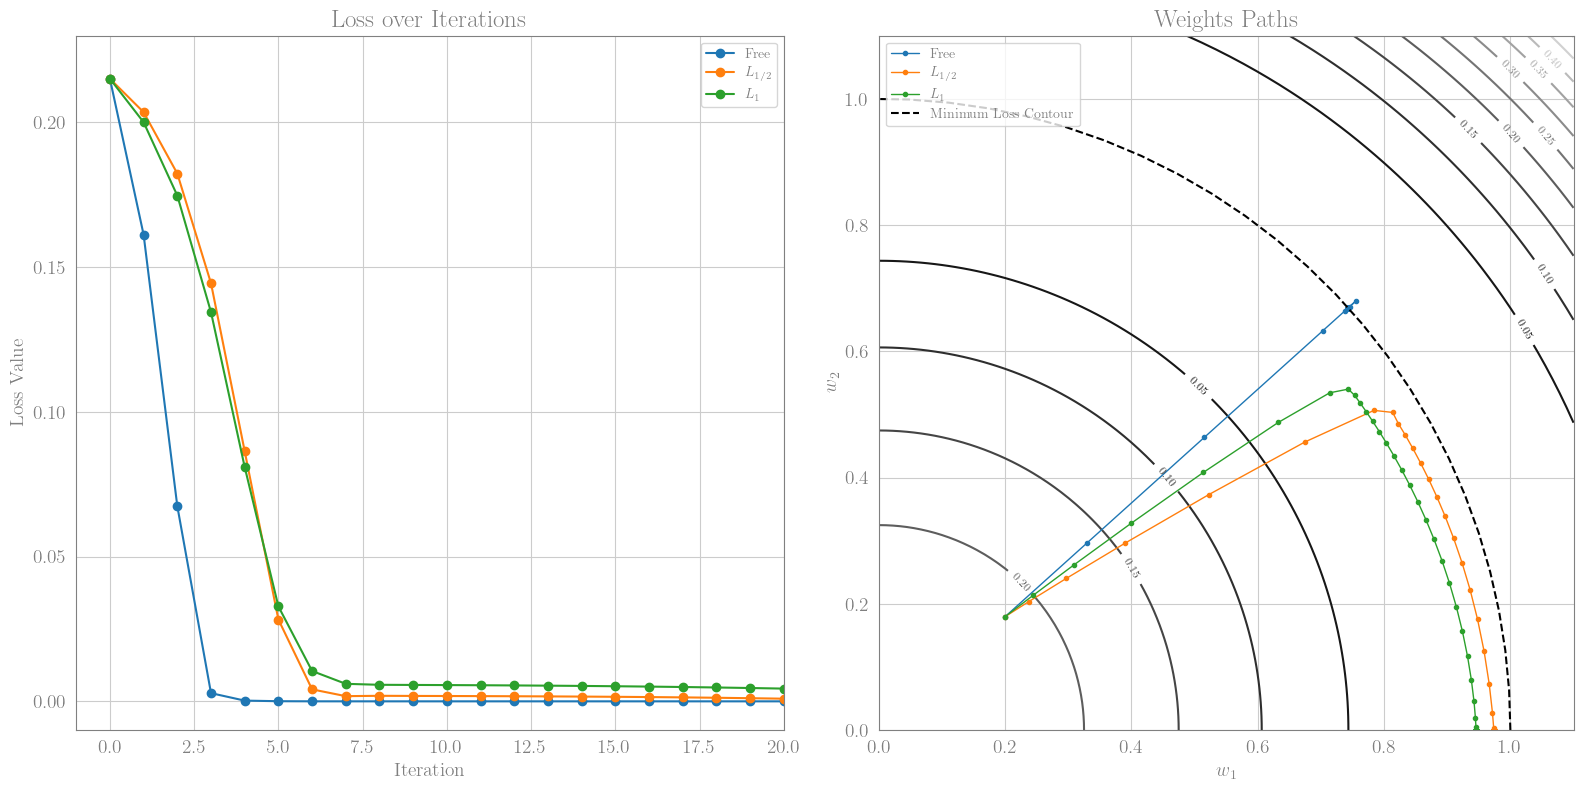

In [37]:
# Define the loss function
def loss(W):
    return 0.25 * (W[:, 0]**2 + W[:, 1]**2 - 1)**2

# Define the gradient of the loss function
def grad_loss(W):
    return W * (W[:, 0]**2 + W[:, 1]**2 - 1)[:, None]

# Initialize weights
W1 = np.array([[0.2, 0.18]])
W2 = np.array([[0.2, 0.18]])
W3 = np.array([[0.2, 0.18]])
LR = 0.7  # Learning rate
LAM = 0.1  # Regularization parameter
p2 = 0.5  # p-norm
p3 = 1.0  # p-norm

# Perform the gradient descent
for i in range(100):
    W1 = np.append(W1, [W1[-1] - LR * grad_loss(W1[-1:])[0]], axis=0)
    
    W2_update = W2[-1] - LR * grad_loss(W2[-1:])[0]
    W2 = np.append(W2, [W2_update * np.abs(W2[-1])**(2 - p2) / (np.abs(W2[-1])**(2 - p2) + p2 * LR * LAM)], axis=0)
    
    W3_update = W3[-1] - LR * grad_loss(W3[-1:])[0]
    W3 = np.append(W3, [W3_update * np.abs(W3[-1])**(2 - p3) / (np.abs(W3[-1])**(2 - p3) + p3 * LR * LAM)], axis=0)
    
    
# Calculate the loss values for plotting
W1_loss_vals = loss(W1)
W2_loss_vals = loss(W2)
W3_loss_vals = loss(W3)

# Function to compute the grid for the contour plot
def compute_loss_contour_grid(x_range, y_range, resolution=100):
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    Z = 0.25 * (X**2 + Y**2 - 1)**2
    return X, Y, Z

# Generate the contour plot grid
x_range = [0, 1.1]
y_range = [0, 1.1]
Xc, Yc, Zc = compute_loss_contour_grid(x_range, y_range)

# Define the side-by-side subplot structure with a shared y-axis
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the grayscale contours of the loss on the left subplot (ax1)
contour = ax1.contour(Xc, Yc, Zc, levels=10, cmap='gray')
ax1.clabel(contour, inline=1, fontsize=8)
ax1.plot(W1[:, 0], W1[:, 1], 'o-', label=r'Free', markersize=3, linewidth=1)
ax1.plot(W2[:, 0], W2[:, 1], 'o-', label=r'$L_{1/2}$', markersize=3, linewidth=1)
ax1.plot(W3[:, 0], W3[:, 1], 'o-', label=r'$L_1$', markersize=3, linewidth=1)
ax1.plot(x_contour, y_contour, 'k--', label=r'Minimum Loss Contour')
ax1.set_xlim([0, 1.1])
ax1.set_ylim([0, 1.1])
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlabel(r'$w_1$', fontsize=14)
ax1.set_ylabel(r'$w_2$', fontsize=14)
ax1.legend(loc='upper left')
ax1.set_title('Weights Paths')

# Semilogy plot for the loss values on the right subplot (ax2)
ax2.plot(W1_loss_vals, 'o-', label=r'Free')
ax2.plot(W2_loss_vals, 'o-', label=r'$L_{1/2}$')
ax2.plot(W3_loss_vals, 'o-', label=r'$L_1$')
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Loss Value', fontsize=14)
ax2.legend()
ax2.set_ylim([-.01, 0.23])
ax2.set_xlim([-1, 20])
ax2.set_title('Loss over Iterations')

# Adjust layout
plt.tight_layout()

# Save the full figure
plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/higgs.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()
